# import library

In [0]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt


2.2.0-rc3


# define helper functions 

In [0]:
def plot_graphs(time, series, format='-', start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('time')
  plt.ylabel('values')
  plt.grid(True)

def trend(time, slope=0):
  return time * slope

def seasonal_pattern(season_time):
  # arbitrary pattern
  return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
  # repeat the same pattern of each period
  season_time = ((time + phase) % period) / period
  return amplitude + seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
  random = np.random.RandomState(seed)
  return random.randn(len(time)) * noise_level

def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):
  # create synthetic data
  ds = tf.data.Dataset.from_tensor_slices(series)
  # expand dataset using windowing
  # size of window = window_size + 1 (to include label)
  # shift window by 1 after populating full dataset
  # drop_remainder= ensure all processed datasets are complete, drop partial datasets
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  # flatten into a numpy list per dataset batch of window_size+label for ML processing
  # use a Lambda to add arbitrary code
  # w= window
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  # shuffle/randomize to reduce sequence bias 
  ds = ds.shuffle(shuffle_buffer_size)
  # map features and labels, last value = label
  ds = ds.map(lambda w: (w[:-1], w[-1]))
  # batch the features and respective labels together
  return ds.batch(batch_size).prefetch(1)



# define hyperparameters

In [0]:
time = np.arange(4 * 365 + 1, dtype='float32')
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000
num_epochs = 500
split_time = 1000

# create series 
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# add noise to the series
series += noise(time, noise_level, seed=42)

# split dataset into train & test series

In [0]:
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

# format dataset

In [0]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# define the model 

this model will be the baseline (pre-optimized learning rate)

In [0]:
model = tf.keras.Sequential([
  # input layer
  # fully connected dense layers map inputs to outputs
  tf.keras.layers.Dense(units=10, activation='relu', input_shape=[window_size]),
  tf.keras.layers.Dense(units=10, activation='relu'),
  # output layer return predicted linear regression value
  tf.keras.layers.Dense(units=1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


# compile the model 

build the model by compiling it with a loss, optimizer, and objective metrics
- loss= prediction accuracy
- the optimizer uses the loss to adjust and improve prediction performance per epoch
- metrics=[performance targets]

In [0]:
# sgd= stochastic gradient descent tracks optimizes at each time_step
sgd = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)

# mse= square values to remove negative values
model.compile(loss='mse', optimizer=sgd)

# train the model

.fit the model to train & learn the optimal weights

assign to a history var for performance querying

In [0]:
history = model.fit(dataset, epochs=num_epochs, verbose=0)

# get baseline forecasts 

model.predict() returns a future numeric value per this model

newaxis= increase the dimension of the existing array by one more dimension

---

**example:** 

if array= `(4,) aka (4, None)` 

*make it as column vector by inserting an axis along second dimension*

```
new_column_vectors = array[:, np.newaxis]
new_column_vectors.shape = (4, 1)
```

if array= `(, 4) aka (None, 4)` 

*make it as row vector by inserting an axis along first dimension*

```
new_row_vectors = [np.newaxis, :]
new_row_vectors.shape = (1, 4)
```

---


In [0]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

# only compare forecasts that align with validation dataset
forecast = forecast[split_time-window_size:]
# convert into numpy format
# [:, 0, 0]= [return all, first, first]
results = np.array(forecast)[:, 0, 0]

# visualize pre-optimal LR forecast performance

mae: 4.24509859085083


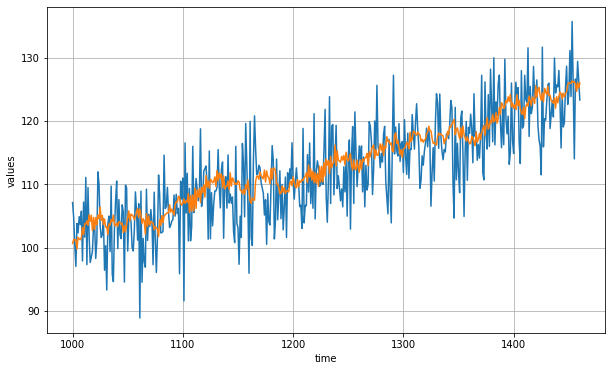

In [0]:
plt.figure(figsize=(10, 6))
plot_graphs(time_valid, x_valid)
plot_graphs(time_valid, results)

# get loss (includes noise)
print('mae: {}'.format(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()))

# define & compile model for optimal learning rate


In [0]:
# format dataset
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [0]:
model = tf.keras.Sequential([
  # input layer
  tf.keras.layers.Dense(units=10, input_shape=[window_size], activation='relu'),
  tf.keras.layers.Dense(units=10, activation='relu'),
  # output layer
  tf.keras.layers.Dense(units=1)
])

sgd = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss='mse', optimizer=sgd)

# define callbacks 

learningRateScheduler:

`the learning rate scheduler will adjust the learning rate for each epoch`


In [0]:
lr_scheduler= tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

# train the model for optimal LR

In [0]:
history = model.fit(dataset, epochs=100, callbacks=[lr_scheduler], verbose=0)

# visualize LR performance 

get loss closest to global minimum via gradient descent

(1e-08, 0.001, 0.0, 300.0)

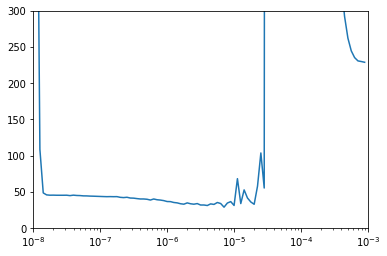

In [0]:
learning_rates = 1e-8 * (10**(np.arange(100)/20))
plt.semilogx(learning_rates, history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 300])

# 10-6 = best 

# train with optimal LR

In [0]:
window_size = 30
# format dataset
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_10 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 431
Trainable params: 431
Non-trainable params: 0
_________________________________________________________________


In [0]:
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)

In [0]:
# already know optimal LR, so no need to include LearningRateScheduler callback
history = model.fit(dataset, epochs=500, verbose=1)

# visualize loss

[25.16033363342285, 24.340499877929688, 24.774839401245117, 25.17221450805664, 24.91288948059082, 25.03470230102539, 24.358312606811523, 25.02051544189453, 24.462539672851562, 25.080076217651367, 24.42724609375, 24.902631759643555, 24.769752502441406, 24.96856117248535, 25.036235809326172, 24.634201049804688, 24.815574645996094, 24.517000198364258, 24.597700119018555, 25.05608367919922, 25.288576126098633, 25.367277145385742, 24.980876922607422, 24.461837768554688, 25.805015563964844, 26.420581817626953, 25.36977195739746, 25.997394561767578, 25.446725845336914, 25.01323127746582, 24.42931365966797, 24.45924949645996, 24.420351028442383, 25.257246017456055, 24.575462341308594, 25.59041976928711, 24.556350708007812, 24.527660369873047, 26.169307708740234, 24.508020401000977, 24.625343322753906, 24.9410457611084, 24.82093620300293, 24.72480583190918, 24.941499710083008, 24.368925094604492, 24.63121223449707, 25.012407302856445, 24.477802276611328, 24.705055236816406, 24.289106369018555, 

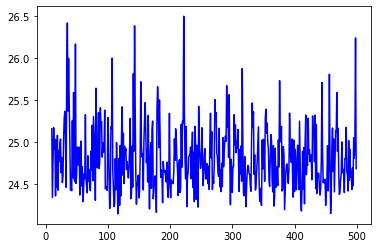

In [0]:
# plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='training loss')
plt.show()

In [0]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

# only compare forecasts that align with validation dataset
forecast = forecast[split_time-window_size:]
# convert into numpy format
# [:, 0, 0]= [return all, first, first]
results = np.array(forecast)[:, 0, 0]

# visualize performance  

loss: 4.191475868225098


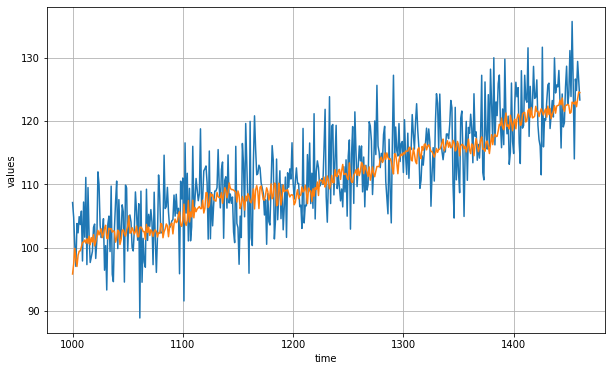

In [0]:
plt.figure(figsize=(10, 6))
plot_graphs(time_valid, x_valid)
plot_graphs(time_valid, results)

print('loss: {}'.format(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()))

# clean up

terminate memory kernel and free up resources 

In [0]:
import os, signal

os.kill(os.getpid(), signal.SIGKILL)